# Product Delivery Overview

---

This model simulates product delivery in USA. The supply chain includes three manufacturing facilities and fifteen distributors that order random amounts of the product – between 500 and 1000, uniformly distributed – each 1 to 2 days (uniformly distributed). There is a fleet of trucks in each manufacturing facility. When a manufacturing facility receives an order from a distributor, it checks the number of products in storage. If the required amount is available, it sends a loaded truck to the distributor. Otherwise, the order waits until the factory produces the sufficient number of products. Orders are queued in FIFO order.

### Complexity

    * The demand coming from each distribution center should be varied:
    * Seasonal change
    * Sudden disruptions/surge in demand

### Observation space

    * Inventory level at each manufacturing location
    * Number of trucks, number of idle vs busy trucks, utilization of fleet at each location
    * Whether manufacturing facility is open or not
    * Average waiting time for orders placed at each manufacturer
    * Average waiting time for all manufacturing facilities

### Action space

    * Production rate of each facility
    * Number of trucks in each facility
    * If a facility should stay open or not

### Reward

    * The reward is driven by minimizing the cost of average wait time across the system.
    
Reinforcement learning algorithms are able to understand and respond to dynamic environments, and their decisions can be game-changing for businesses operating complex distribution networks. 

### 1. Start the Environment

We begin by importing the necessary packages. 

First import the Communicator class of the supplied module.

In [ ]:
from al_rlexp_communicator import Communicator

In [1]:
import numpy as np

In [2]:
import random
import copy
import matplotlib.pyplot as plt
%matplotlib inline
import time

In [3]:
import torch
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.utils as U

In [4]:
from collections import namedtuple, deque

In [5]:
from model import Actor, Critic
from utils import sample, update_targets, OUNoise

In [6]:
## Hyperparameters

## For Experience Replay
BUFFER_SIZE = int(1e6)  # replay buffer size
BATCH_SIZE = 128         # minibatch size

## For Fixed-Q Target
TAU = 1e-3              # for soft update of target parameters
UPDATE_EVERY = 20       # how often to update the network. 
UPDATE_TIMES = 10       # and how many times to update

# For Cumulative Reward
GAMMA = 0.99            # discount factor

## For Q Network
LR_ACTOR = 1e-3         # learning rate of the actor
LR_CRITIC = 1e-3        # learning rate of the critic

WEIGHT_DECAY = 0        # L2 weight decay

OU_SIGMA = 0.2          # Ornstein-Uhlenbeck noise parameter
OU_THETA = 0.15         # Ornstein-Uhlenbeck noise parameter

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [8]:
state_size = 23
action_size = 9
random_seed = 1
random.seed(random_seed)

In [9]:
# Actor Network (w/ Target Network)
actor_local = Actor(state_size, action_size, random_seed).to(device)
actor_target = Actor(state_size, action_size, random_seed).to(device)
actor_optimizer = optim.Adam(actor_local.parameters(), lr=LR_ACTOR)

In [10]:
# Critic Network (w/ Target Network)
critic_local = Critic(state_size, action_size, random_seed).to(device)
critic_target = Critic(state_size, action_size, random_seed).to(device)
critic_optimizer = optim.Adam(critic_local.parameters(), lr=LR_CRITIC, weight_decay=WEIGHT_DECAY)

In [11]:
update_targets(critic_local, critic_target)
update_targets(actor_local, actor_target)        

In [12]:
# some util and data variables
mu = 0.
replay_memory = deque(maxlen=BUFFER_SIZE)
experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
# Noise process
noise = OUNoise(action_size, random_seed, mu, OU_SIGMA, OU_THETA)

Next, we will start the environment! 

Create a new instance of Communicator, passing the directory of the exported model folder (the one containing “model.jar”)

In [ ]:
com = Communicator("ProductDeliveryExported")

After executing this, your model will be launched in a separate process. If on Windows, you may see a terminal window pop up; you can ignore it or minimize it, but do not close it out.

Communication now happens by receiving from and sending messages to the model.

### 2. Examine the State and Action Spaces

In this environment, each order generated at any of the distributors will determine which manufacturer can fulfill the order most quickly. A reward of `[1, -1]` is provided for each step that is calculated using a reward function built around turnaround time and cost per product. Thus, the goal of our agent is to minimizing the cost of average wait time across the system.

The observation space consists of `23` variables corresponding to inventory level, number of trucks, and average waiting time at each manufacturer facility.  Each action is a vector with 3 numbers, corresponding to 3 manufacturing facilities.

Run the code cell below to print some information about the environment.

In [15]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 20
Size of each action: 4
There are 20 agents. Each observes a state with length: 33
The state for the first agent looks like: [ 0.00000000e+00 -4.00000000e+00  0.00000000e+00  1.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.00000000e+01  0.00000000e+00
  1.00000000e+00 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  5.75471878e+00 -1.00000000e+00
  5.55726624e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
 -1.68164849e-01]


### 3. Take Random Actions in the Environment (Optional Step)

In the next code cell, we will learn how to use the Python API to control the agent and receive feedback from the environment.

In [18]:
env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
states = env_info.vector_observations                  # get the current state (for each agent)
scores = np.zeros(num_agents)                          # initialize the score (for each agent)
steps = 0
while True:
    actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
    actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
    env_info = env.step(actions)[brain_name]           # send all actions to tne environment
    next_states = env_info.vector_observations         # get next state (for each agent)
    rewards = env_info.rewards                         # get reward (for each agent)
    dones = env_info.local_done                        # see if episode finished
    scores += env_info.rewards                         # update the score (for each agent)
    states = next_states                               # roll over states to next time step
    steps += 1
    if np.any(dones):                                  # exit loop if episode finished
        break
print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))
print('Total steps in this episode: {}'.format(steps))

Total score (averaged over agents) this episode: 0.135499996971339
Total steps in this episode: 1001


### 4. Define Agent

In [16]:
## Agent - one of the core logic of DDPG - To run INFERENCE on Actor Neural Network
def agent(state, add_noise=True):
    """Returns actions for given state as per current policy."""
    state = torch.from_numpy(state).float().to(device)
    actor_local.eval()
    with torch.no_grad():
        action = actor_local(state).cpu().data.numpy()
    actor_local.train()
    if add_noise:
        action +=noise.sample()
    return np.clip(action, -1, 1)

### 5. Define Training of the Agent

Or go straight to step 8 to test agent loaded with previuous trained weights (in its Neural Network)

In [17]:
## Train Agent - One of the core logic of DDPG - To TRAIN Actor and Critic Neural NETWORK
def train_agent(state, action, reward, next_state, done, timestep):
    """Update policy and value parameters using given batch of experience tuples.
    Q_targets = r + γ * critic_target(next_state, actor_target(next_state))
    where:
        actor_target(state) -> action
        critic_target(state, action) -> Q-value

    Params
    ======
        experiences (Tuple[torch.Tensor]): tuple of (s, a, r, s', done) tuples 
        gamma (float): discount factor
    """
    """Save experience in replay memory, and use random sample from buffer to learn."""
       
    e = experience(state, action, reward, next_state, done)
    # Save experience / reward
    replay_memory.append(e)
        
    # Learn, if enough samples are available in memory
    if len(replay_memory) > BATCH_SIZE and timestep % UPDATE_EVERY == 0:
        for _ in range(UPDATE_TIMES):
            
            experiences = sample(replay_memory, BATCH_SIZE)
            states, actions, rewards, next_states, dones = experiences

            # ---------------------------- update critic ---------------------------- #
            # Get predicted next-state actions and Q values from target models
            actions_next = actor_target(next_states)
            Q_targets_next = critic_target(next_states, actions_next)
            # Compute Q targets for current states (y_i)
            Q_targets = rewards + (GAMMA * Q_targets_next * (1 - dones))
            # Compute critic loss
            Q_expected = critic_local(states, actions)
            critic_loss = F.mse_loss(Q_expected, Q_targets)
            # Minimize the loss
            critic_optimizer.zero_grad()
            critic_loss.backward()
            U.clip_grad_norm_(critic_local.parameters(), 1)
            critic_optimizer.step()


            # ---------------------------- update actor ---------------------------- #
            # Compute actor loss
            actions_pred = actor_local(states)
            actor_loss = -critic_local(states, actions_pred).mean()
            # Minimize the loss
            actor_optimizer.zero_grad()
            actor_loss.backward()
            actor_optimizer.step()

            # ----------------------- update target networks ----------------------- #
            update_targets(critic_local, critic_target, TAU)
            update_targets(actor_local, actor_target, TAU) 

### 6. Main Function - Define Training 

Or go straight to step 8 to test agent loaded with previuous trained weights (in its Neural Network)

In [18]:
def ddpg(n_episodes=500, max_t=1000, solved_score=30.0, consec_episodes=100, print_every=1, old_episodes=0, old_mov_avg=0.0):
    
    mean_scores = []                               # list of mean scores from each episode
    min_scores = []                                # list of lowest scores from each episode
    max_scores = []                                # list of highest scores from each episode
    best_score = -np.inf
    scores_deque = deque(maxlen=consec_episodes)   # mean scores from most recent episodes
    moving_avgs = []                               # list of moving averages    
    
    for i_episode in range(1, n_episodes+1):
        #reset the environment, noise and score
        env_info = env.reset(train_mode=True)[brain_name] # reset the environment
        states = env_info.vector_observations             # get current state for each agent
        noise.reset()                                     # reset the noise
        scores = np.zeros(num_agents)                     # initialize scores for each agent
        start_time = time.time()
        
        for t in range(max_t):
            actions = agent(states, add_noise=True)       # select actions with exploration
            env_info = env.step(actions)[brain_name]      # send actions to the environment
            next_states = env_info.vector_observations    # get next states
            rewards = env_info.rewards                    # get the rewards 
            dones = env_info.local_done
            
            # save experience to replay buffer, perform learning step at defined interval
            for state, action, reward, next_state, done in zip(states, actions, rewards, next_states, dones):            
                train_agent(state, action, reward, next_state, done, t) # train Actor and Crtic Neural Network
            
            states = next_states
            
            scores += rewards                             # add rewards to current scores 
 
            if np.any(dones):            # exit loop when episode ends
                break     
        
        duration = time.time() - start_time
        min_scores.append(np.min(scores))             # save lowest score for a single agent
        max_scores.append(np.max(scores))             # save highest score for a single agent        
        mean_scores.append(np.mean(scores))           # save mean score for the episode
        scores_deque.append(mean_scores[-1])          # save mean score to deque
        moving_avgs.append(np.mean(scores_deque))     # save moving average     
        
        if i_episode % print_every == 0:
            print('\rEpisode {} ({} sec)  -- \tMin: {:.1f}\tMax: {:.1f}\tMean: {:.1f}\tMov. Avg: {:.1f}'.format(\
                  i_episode, round(duration), min_scores[-1], max_scores[-1], mean_scores[-1], moving_avgs[-1])) 
            
        if mean_scores[-1] > best_score:
            torch.save(actor_local.state_dict(), 'checkpoint_actor1.pth')
            torch.save(critic_local.state_dict(), 'checkpoint_critic1.pth')  
         
        real_episode = i_episode + old_episodes
        real_moving_avgs = (moving_avgs[-1]*i_episode + old_mov_avg*old_episodes)/real_episode
        
        if i_episode % (print_every + 3) == 0:
            print('\rIncluding Previous Runs -- Total Episodes {}  -- \tReal Mov. Avg: {:.1f}'.format(\
                  real_episode, real_moving_avgs)) 
        
        if real_moving_avgs >= solved_score and real_episode >= consec_episodes:
            print('\nEnvironment SOLVED in {} episodes!\tMoving Average ={:.1f} over last {} episodes'.format(\
                                    real_episode-consec_episodes, real_moving_avgs, consec_episodes))    
            torch.save(actor_local.state_dict(), 'checkpoint_actor1.pth')
            torch.save(critic_local.state_dict(), 'checkpoint_critic1.pth')
            break

            
    return mean_scores, moving_avgs

### 7. Start Training (Optional) - 1st Run
### (Skip to step 8 to test the environment with trained agent)

In [ ]:
# run the training loop
scores, avgs = ddpg()

### 7. Continue Training (Optional) - 2nd Run
### (Skip to step 8 to test the environment with trained agent)

In [ ]:
# run the training loop with the saved weights from the previous run
actor_local.load_state_dict(torch.load('checkpoint_actor.pth'))
critic_local.load_state_dict(torch.load('checkpoint_critic.pth'))
update_targets(critic_local, critic_target)
update_targets(actor_local, actor_target)    
scores, avgs = ddpg()

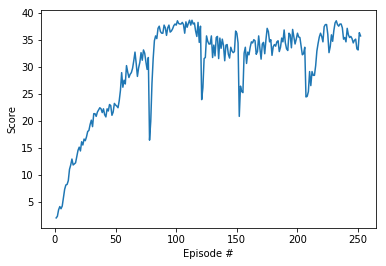

In [55]:
# plot the scores from all the runs
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores_from_all_runs)+1), scores_from_all_runs)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

### 8. Test Trained Agent in the Environment

Once this cell is executed, we can watch the agent's performance.  

In [25]:
#Load the previous trained weights
#Need to turn on the GPU to even test it. Otherwise torch load results in error. 
actor_local.load_state_dict(torch.load('checkpoint_actor.pth'))
critic_local.load_state_dict(torch.load('checkpoint_critic.pth'))

env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
states = env_info.vector_observations                  # get the current state (for each agent)
scores = np.zeros(num_agents)                          # initialize the score (for each agent)
steps = 0
while True:
    actions = agent(states, add_noise=False) 
    env_info = env.step(actions)[brain_name]           # send all actions to tne environment
    next_states = env_info.vector_observations         # get next state (for each agent)
    rewards = env_info.rewards                         # get reward (for each agent)
    dones = env_info.local_done                        # see if episode finished
    scores += env_info.rewards                         # update the score (for each agent)
    states = next_states                               # roll over states to next time step
    steps += 1
    if np.any(dones):                                  # exit loop if episode finished
        break
print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))
print('Total steps in this episode: {}'.format(steps))

Total score (averaged over agents) this episode: 35.21199921295047
Total steps in this episode: 1001


When finished, you can close the environment.

In [21]:
env.close()